# Time Series E2E Exercise

### James Allen

You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).

- Use the data from this kaggle competition: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [1]:
# imports
import pandas as pd
import numpy as np
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# getting the climate change data
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [3]:
df.head() # check_yo_head

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


Initial Thoughts:

- I will need to rename the column names to make them easier to use
- I only want to use one 'City': I am goin to use 'Sacramento'
- The latitude and longitude will not change since I am using only one city
- After getting my 'Sacramento' data I can drop columns that I do not need
- I will need to remove leap days and check for nulls in the data
- I will need to convert the date to_datetime

In [4]:
# selecting my hometown on "Sacramento", California
# 'smf' is the airport code for Sacramento
smf_df = df[df['City'] == "Sacramento"]

In [5]:
smf_df.head() # check_yo_head

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
6506228,1849-01-01,8.092,2.192,Sacramento,United States,37.78N,122.03W
6506229,1849-02-01,9.508,1.850,Sacramento,United States,37.78N,122.03W
6506230,1849-03-01,11.701,2.129,Sacramento,United States,37.78N,122.03W
6506231,1849-04-01,13.102,2.559,Sacramento,United States,37.78N,122.03W
6506232,1849-05-01,14.045,1.909,Sacramento,United States,37.78N,122.03W


In [6]:
# taking a look at the shape of the "Sacramento" data
smf_df.shape

(1977, 7)

In [7]:
# taking a look at the info and Dtype of the "Sacramento" data
smf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 6506228 to 6508204
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             1977 non-null   object 
 1   AverageTemperature             1977 non-null   float64
 2   AverageTemperatureUncertainty  1977 non-null   float64
 3   City                           1977 non-null   object 
 4   Country                        1977 non-null   object 
 5   Latitude                       1977 non-null   object 
 6   Longitude                      1977 non-null   object 
dtypes: float64(2), object(5)
memory usage: 123.6+ KB


### Now I can do some prep on the 'Sacramento' data

In [8]:
# renaming columns for use and readability 
smf_df.rename(columns={'AverageTemperature':'avg_temp', 'dt':'date'}, inplace=True)

In [9]:
# dropping columns that are not needed
smf_df = smf_df.drop(['AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude'], axis = 1)

In [10]:
# changing'avg_temp' to integers
# smf_df.avg_temp = smf_df.avg_temp.astype(int)
# did not end up needing to convert to int but leaving here for future exploration

In [11]:
# setting 'date' to datetime
smf_df.date = pd.to_datetime(smf_df.date)

In [12]:
# remove leap days
smf_df = smf_df[smf_df.index!='2016-02-29']

In [13]:
# a datetime index is probably a good idea
smf_df = smf_df.set_index('date').sort_index()

In [14]:
smf_df.head() # check_yo_head

,avg_temp
date,
1849-01-01,8.092
1849-02-01,9.508
1849-03-01,11.701
1849-04-01,13.102
1849-05-01,14.045


In [15]:
# checking for nulls in the data
smf_df.isna().sum()

avg_temp    0
dtype: int64

In [16]:
# checking the size of the data using len() function
df_size = len(smf_df)
df_size

1977

In [17]:
# looking a half of the data .5
len(smf_df) * .5

988.5

# Setting up the data to get ready to split

In [18]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(smf_df) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(smf_df) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(smf_df) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

In [19]:
# split into train, validation, test
train = smf_df[: train_size]
validate = smf_df[train_size : validate_end_index]
test = smf_df[validate_end_index : ]

In [20]:
# sum of train, validate and test = total number of rows? 
print(len(train) + len(validate) + len(test) == len(smf_df))

True


In [21]:
# test the row starts
print(smf_df.head(1) == train.head(1))

            avg_temp
date                
1849-01-01      True


In [22]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,avg_temp
date,
1980-09-01,18.558
1980-10-01,16.966


In [23]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), smf_df.tail(1)])

,avg_temp
date,
2013-09-01,20.471
2013-09-01,20.471


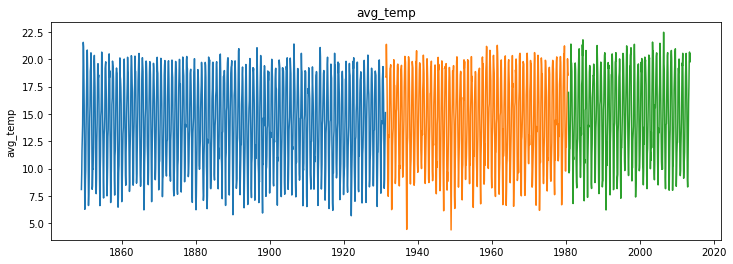

In [24]:
# plot the data points, color by train, validate, test
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Creating and Defining functions to use on the Sacramento Data

In [25]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values and compute the 
    mean squared error and then take the square root and round to zero decimals
    it will return the rmse 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [26]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    
    plt.show()

In [27]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [28]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [29]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the mode_type as a string, the target variable as a string
    and rund the evaluate() function to compute the rmse,
    and append the dataframe a row with the model_type, target_var, and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Last Observed Value

### The simplest method for forecasting is to predict all future values to be the last observed value.

In [30]:
# make predictions
# taking the last observation
temp = round(train['avg_temp'][-1:][0], 2)
temp

15.12

In [31]:
# make predictions
yhat_df = pd.DataFrame({'avg_temp': [temp]}, 
                       index = validate.index)

yhat_df.head(2)

,avg_temp
date,
1931-05-01,15.12
1931-06-01,15.12


avg_temp -- RMSE: 4


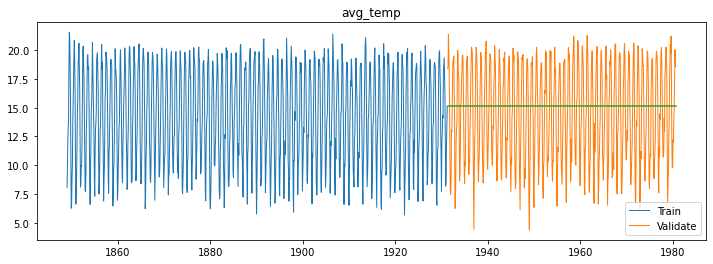

In [32]:
# plotting actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [33]:
# evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [34]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,4.0


# Simple Average

### Take the simple average of historical values and use that value to predict future values.

In [35]:
# make predictions
avg_temp = round(train['avg_temp'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [avg_temp],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [36]:
yhat_df.head() # check_yo_head

,avg_temp
date,
1931-05-01,14.22
1931-06-01,14.22
1931-07-01,14.22
1931-08-01,14.22
1931-09-01,14.22


avg_temp -- RMSE: 4


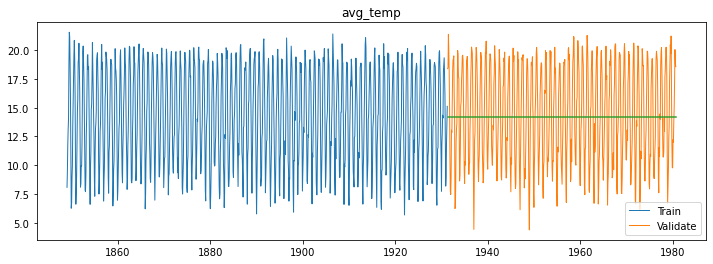

In [38]:
# plotting actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [39]:
# evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [40]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,4.0
1,simple_average,avg_temp,4.0


# Moving Average

In [41]:
# compute a 30 day rolling average,
# use the most recent/last 30 day period value to predict forward.
period = 30

avg_temp = round(train['avg_temp'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,avg_temp
date,
1931-05-01,13.68
1931-06-01,13.68
1931-07-01,13.68


avg_temp -- RMSE: 4


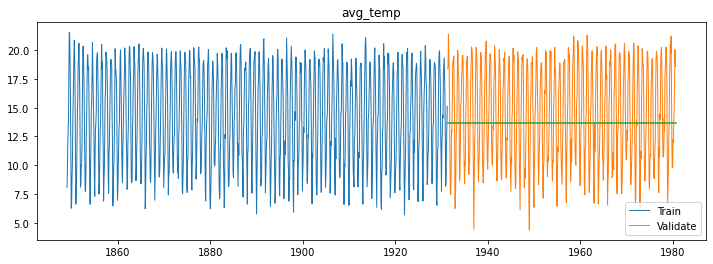

In [42]:
# plotting actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [43]:
# evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

In [44]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,4.0
1,simple_average,avg_temp,4.0
2,30d moving average,avg_temp,4.0


In [45]:
# Let's try out several other values for periods

periods = [1, 15, 30, 45, 60, 75, 90]

for p in periods:
    avg_temp = round(train['avg_temp'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'avg_temp'
                            )

In [46]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,4.0
1,simple_average,avg_temp,4.0
2,30d moving average,avg_temp,4.0
3,1d moving average,avg_temp,4.0
4,15d moving average,avg_temp,4.0
5,30d moving average,avg_temp,4.0
6,45d moving average,avg_temp,4.0
7,60d moving average,avg_temp,4.0
8,75d moving average,avg_temp,4.0
9,90d moving average,avg_temp,4.0


In [47]:
# Which is best so far?
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [48]:
# evaluation metrics on eval_df
eval_df[((eval_df.rmse == min_rmse_amount)
        )]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,4.0
1,simple_average,avg_temp,4.0
2,30d moving average,avg_temp,4.0
3,1d moving average,avg_temp,4.0
4,15d moving average,avg_temp,4.0
5,30d moving average,avg_temp,4.0
6,45d moving average,avg_temp,4.0
7,60d moving average,avg_temp,4.0
8,75d moving average,avg_temp,4.0
9,90d moving average,avg_temp,4.0


# Holt's Linear Trend


In [49]:
# setting up for plots
plt.rc('figure', figsize=(12, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

avg_temp 



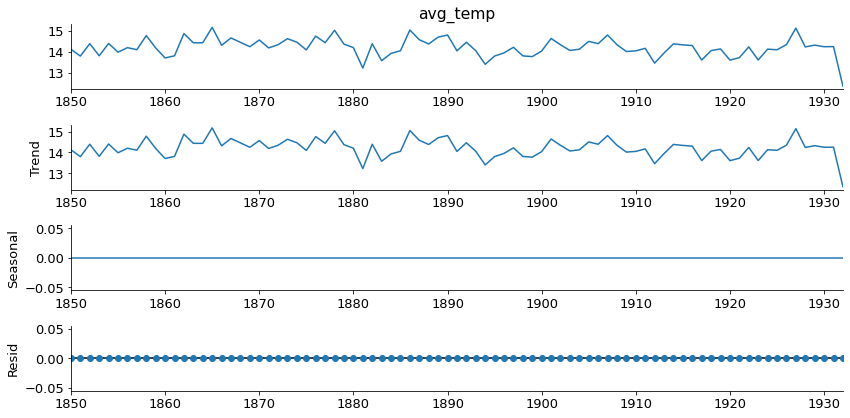

In [50]:
# First, let's take a look at the seasonal decomposition for each target.
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('1Y').mean()).plot()
    plt.show()

In [51]:
# Make Predictions
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

avg_temp -- RMSE: 18


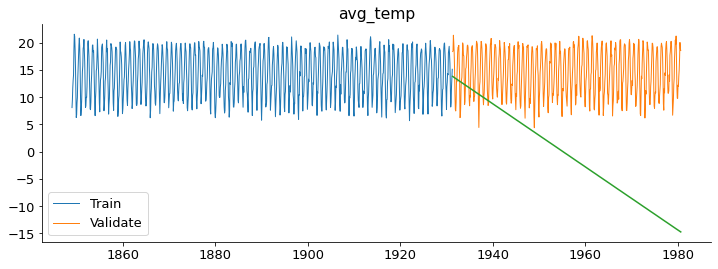

In [52]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [53]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [54]:
# evaluation metrics on eval_df
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,4.0
1,simple_average,avg_temp,4.0
2,30d moving average,avg_temp,4.0
3,1d moving average,avg_temp,4.0
4,15d moving average,avg_temp,4.0
5,30d moving average,avg_temp,4.0
6,45d moving average,avg_temp,4.0
7,60d moving average,avg_temp,4.0
8,75d moving average,avg_temp,4.0
9,90d moving average,avg_temp,4.0


# Predict Based on Previous Cycle

In [55]:
# looking at the last dates in the data
smf_df.tail()

,avg_temp
date,
2013-05-01,17.434
2013-06-01,19.759
2013-07-01,20.657
2013-08-01,19.731
2013-09-01,20.471


In [56]:
# re-split data
train = smf_df[:'2010']
validate = smf_df['2011']
test = smf_df['2012']

In [57]:
# make predictions
yhat_df = train['2010'] + train.diff(3).mean()

In [58]:
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2010-01-01,9.60404
2011-01-01,9.35900


In [59]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

12

avg_temp -- RMSE: 1


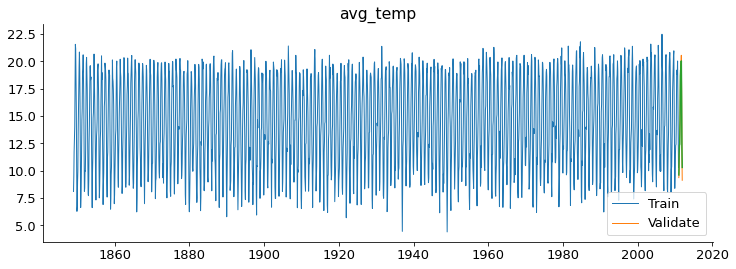

In [60]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

# Conclusion

Which model did the best?

In [61]:
# get the min rmse for each variable
min_rmse_avg_temp = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[(eval_df.rmse == min_rmse_avg_temp)]

,model_type,target_var,rmse
11,previous year,avg_temp,1.0


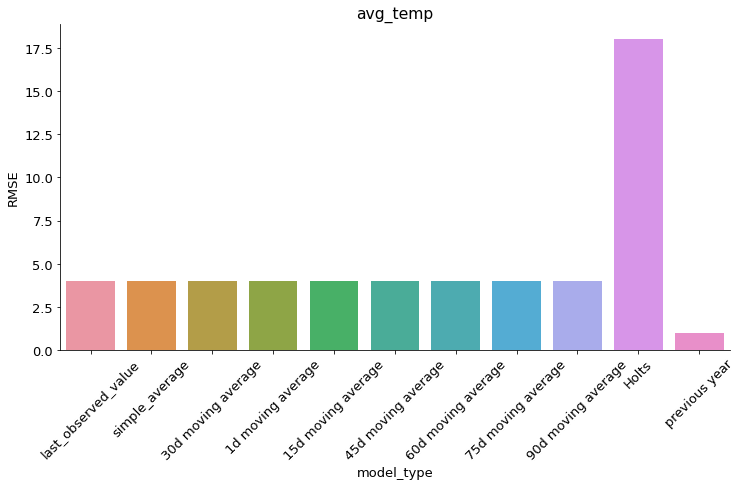

In [62]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

# Let's test it out on our out-of-sample data

## We will be using train + validate to predict test.

In [82]:
yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [83]:
rmse_avg_temp = round(sqrt(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'])), 0)

In [86]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.xlim(left=2000)
    plt.title(target_var)
    plt.legend()
    plt.show()

rmse - avg_temp:  0.0


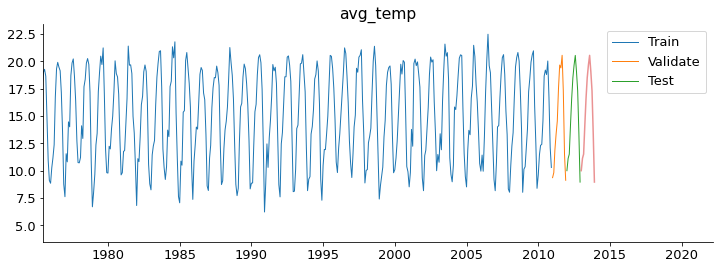

In [87]:
print("rmse - avg_temp: ", rmse_avg_temp)

for col in train.columns:
    plot_and_eval(col)

In [74]:
# average temperature
yhat_df.mean()

avg_temp    15.055004
dtype: float64

# Takeaways
- Previous year had the best rmse 1.0
- Average temperature 15.05